In [1]:
import jax
import jax.numpy as np

from numpy.polynomial.hermite import hermgauss

from structure_vb_lib import structure_model_lib, posterior_quantities_lib, data_utils, plotting_utils
import structure_vb_lib.structure_optimization_lib as s_optim_lib

from bnpmodeling_runjingdev import result_loading_utils
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation
from bnpmodeling_runjingdev.bnp_optimization_lib import optimize_kl

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
seed = 98765
onp.random.seed(seed)

In [3]:
save_data = True
out_datadir = '/scratch/users/genomic_times_series_bnp/bnp_sensitivity_paper_data/structure/'

# Load data

In [4]:
g_obs, _, labels, _ = data_utils.load_thrush_data()

loading thrush data from : 
../data/thrush_data/thrush-data.str


In [5]:
print(g_obs.shape)

(155, 7, 2, 21)


In [6]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]
n_allele = g_obs.shape[-1]

In [7]:
onp.unique(labels)

array(['Chawia', 'Mbololo', 'Ngangao', 'Yale'], dtype='<U32')

# Get prior

In [8]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params(n_allele)

alpha0 = 3.0
prior_params_dict['dp_prior_alpha'] = alpha0

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'dp_prior_alpha': 3.0, 'allele_prior_lambda_vec': DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1.], dtype=float64)}


# Get VB params 

In [9]:
k_approx = 20

In [10]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [11]:
vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs = n_obs,
                                                      n_loci = n_loci,
                                                      n_allele = n_allele, 
                                                      k_approx = k_approx, 
                                                      prng_key = jax.random.PRNGKey(seed))
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_dirichlet_params] = NumericArrayPattern (20, 7, 21) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (155, 19) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (155, 19) (lb=0.0, ub=inf)


# Initialize

In [12]:
structure_model_lib.get_kl(g_obs, 
                           vb_params_dict, 
                           prior_params_dict, 
                           gh_loc, 
                           gh_weights)

DeviceArray(21146.61530633, dtype=float64)

In [13]:
t0 = time.time() 

vb_params_dict = s_optim_lib.initialize_structure(g_obs, 
                                                  vb_params_dict, 
                                                  vb_params_paragami,
                                                  prior_params_dict, 
                                                  gh_loc, 
                                                  gh_weights, 
                                                  seed = seed)

print('Initialization time: {:.03f}secs'.format(time.time() - t0))

Initialization time: 9.646secs


In [14]:
structure_model_lib.get_kl(g_obs, 
                           vb_params_dict, 
                           prior_params_dict, 
                           gh_loc, 
                           gh_weights)

DeviceArray(19627.88370782, dtype=float64)

# Optimize

In [15]:
vb_opt_dict, vb_opt, ez_opt, out, init_optim_time = \
    s_optim_lib.optimize_structure(g_obs,
                                   vb_params_dict,
                                   vb_params_paragami,
                                   prior_params_dict, 
                                   gh_loc, 
                                   gh_weights)

compiling objective and derivatives ... 
done. Compile time: 44.569sec
Running L-BFGS-B ...
L-BFGS-B time: 4.172sec
BFGS out:  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Running trust-ncg ... 
Newton time: 2.688sec
Newton out:  Optimization terminated successfully.
done. 


In [16]:
init_optim_time

6.870339393615723

In [17]:
out.fun

array(13533.40950931)

In [18]:
# save the fit for later
paragami.save_folded('./initial_fit', 
                     vb_opt_dict, 
                     vb_params_paragami, 
                     final_kl = out.fun, 
                     alpha0 = alpha0)

# Check out the fit

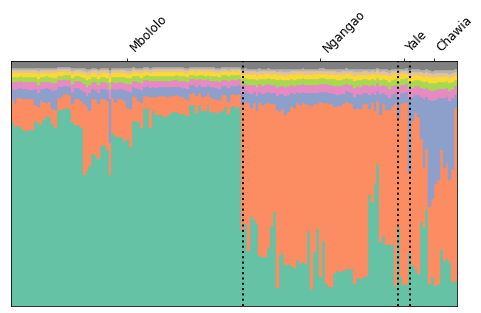

In [19]:
e_ind_admix = posterior_quantities_lib.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]

# sort everything within populations
perm_obs = data_utils.cluster_admix_get_indx_within_labels(onp.array(e_ind_admix),
                                                               labels)

# now re-order populations: put chawia last
_labels = deepcopy(labels)
_labels[_labels == 'Chawia'] = 'z'
perm_labels = onp.argsort(_labels)
perm_obs = perm_obs[perm_labels]

# plot admixture
fig, ax = plt.subplots(1, 1, figsize = (8, 4.5))

plotting_utils.plot_top_clusters(onp.array(e_ind_admix)[perm_obs], 
                                 ax,
                                 8, 
                                 cmap_colors = plt.get_cmap('Set2').colors);

# print labels
plotting_utils.draw_region_separation(labels[perm_labels], ax);

In [20]:
# save the intitial fit for plotting
if save_data: 
    np.savez(out_datadir + 'init_fit', 
            e_ind_admix = e_ind_admix[perm_obs], 
            labels = labels[perm_labels])

In [21]:
e_num_loci_per_cluster = posterior_quantities_lib.get_e_num_loci_per_cluster(g_obs, vb_opt_dict, gh_loc, gh_weights)
e_num_ind_per_cluster = posterior_quantities_lib.get_e_num_ind_per_cluster(vb_opt_dict, gh_loc, gh_weights)

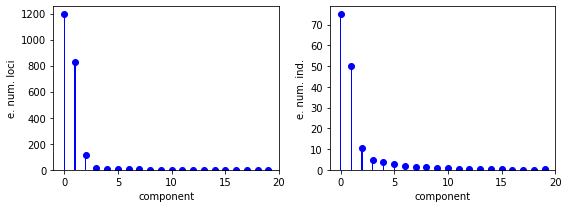

In [22]:
fig, axarr = plt.subplots(1, 2, figsize = (8, 3))

result_loading_utils._plot_weights(e_num_loci_per_cluster, 
                                   axarr[0])

result_loading_utils._plot_weights(e_num_ind_per_cluster, 
                                   axarr[1])


axarr[0].set_ylabel('e. num. loci')
axarr[1].set_ylabel('e. num. ind.')
    
fig.tight_layout()

# Define sensitivity object

In [23]:
# initial prior alpha
use_free_alpha = True
hyper_param0 = prior_params_paragami['dp_prior_alpha'].flatten(alpha0, 
                                                              free = use_free_alpha)[0]

print(hyper_param0)

1.0986122886681098


In [24]:
# set up objective as function of vb params and prior param 

def objective_fun(vb_params_dict, alpha): 
    
    _prior_params_dict = deepcopy(prior_params_dict)
    _prior_params_dict['dp_prior_alpha'] = alpha
    
    return structure_model_lib.get_kl(g_obs, 
                          vb_params_dict,
                          _prior_params_dict,
                          gh_loc, 
                          gh_weights).squeeze()


objective_fun_free = paragami.FlattenFunctionInput(
                                original_fun=objective_fun, 
                                patterns = [vb_params_paragami, prior_params_paragami['dp_prior_alpha']],
                                free = [True, use_free_alpha],
                                argnums = [0, 1])

### The sensitivity object

In [25]:
vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun_free,
                                                        vb_opt,
                                                        hyper_param0)

Compiling hessian solver ...
Hessian solver compile time: 69.3847sec

Compiling cross hessian...
Cross-hessian compile time: 0.562831sec

LR sensitivity time: 0.332631sec



In [26]:
# double check the timing ... 

n_trials = 10
hess_solve_time_samples = onp.zeros(n_trials)
for i in range(n_trials): 
    # this sets the cross-hessian and solves
    # we call "block_util_ready()" inside this method
    # so it should be a fair comparison
    vb_sens._set_dinput_dhyper()
    
    hess_solve_time_samples[i] = vb_sens.lr_time

hess_solve_time = hess_solve_time_samples.mean()

LR sensitivity time: 0.284218sec

LR sensitivity time: 0.31775sec

LR sensitivity time: 0.294182sec

LR sensitivity time: 0.340014sec

LR sensitivity time: 0.319709sec

LR sensitivity time: 0.313629sec

LR sensitivity time: 0.306974sec

LR sensitivity time: 0.302479sec

LR sensitivity time: 0.318126sec

LR sensitivity time: 0.353292sec



# Fit for a range of alpha

### Define loss as function of free params and alpha
and we precompile its derivatives beforehand

In [27]:
get_fun = jax.jit(objective_fun_free)

get_grad = jax.jit(jax.grad(objective_fun_free, argnums = 0))

def _get_hvp(x, hyper_param0, v):
    return jax.jvp(jax.grad(objective_fun_free, argnums = 0), (x, hyper_param0), (v, 0.))[1]

get_hvp = jax.jit(_get_hvp)

In [28]:
# compile ... 
_ = get_fun(vb_opt, hyper_param0).block_until_ready()
_ = get_grad(vb_opt, hyper_param0).block_until_ready()
_ = get_hvp(vb_opt, hyper_param0, vb_opt).block_until_ready()

In [29]:
def refit_with_alpha(alpha, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    hyper_param0 = prior_params_paragami['dp_prior_alpha'].flatten(alpha, free = use_free_alpha)[0]
    
    _, vb_opt_pert, _, refit_time = \
        optimize_kl(lambda x : get_fun(x, hyper_param0),
                     new_init_dict, 
                     vb_params_paragami, 
                     get_grad = lambda x : get_grad(x, hyper_param0),
                     get_hvp = lambda x, v: get_hvp(x, hyper_param0, v),
                     run_lbfgs = False,
                     run_newton = True)                         
        
    return vb_opt_pert, refit_time

In [30]:
alpha_list1 = np.arange(alpha0, 0, step = -1, dtype = float)
alpha_list2 = np.arange(alpha0 + 1, 14, step = 1, dtype = float)

In [31]:
refit_list = []
refit_time_vec = []

new_init_dict = deepcopy(vb_opt_dict)

for alpha in alpha_list1: 
    print('\n################')
    print('re-optimzing with alpha = ', alpha)
    print('################')
    
    refit_free, refit_time = refit_with_alpha(alpha, new_init_dict)
    
    refit_list.append(refit_free)
    refit_time_vec.append(refit_time)
    
    new_init_dict = vb_params_paragami.fold(refit_free, free = True)

# continue refits with second set of alphas
new_init_dict = deepcopy(vb_opt_dict)

for alpha in alpha_list2: 
    print('\n################')
    print('re-optimzing with alpha = ', alpha)
    print('################')
    
    refit_free, refit_time = refit_with_alpha(alpha, new_init_dict)
    
    refit_list.append(refit_free)
    refit_time_vec.append(refit_time)
    
    new_init_dict = vb_params_paragami.fold(refit_free, free = True)



################
re-optimzing with alpha =  3.0
################
compiling objective and derivatives ... 
done. Compile time: 2.919sec
Running trust-ncg ... 
Newton time: 0.039sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with alpha =  2.0
################
compiling objective and derivatives ... 
done. Compile time: 2.838sec
Running trust-ncg ... 
Newton time: 6.223sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with alpha =  1.0
################
compiling objective and derivatives ... 
done. Compile time: 2.798sec
Running trust-ncg ... 
Newton time: 9.723sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with alpha =  4.0
################
compiling objective and derivatives ... 
done. Compile time: 2.796sec
Running trust-ncg ... 
Newton time: 6.635sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with alpha = 

In [32]:
# put everythin in order 
alpha_list = np.concatenate((alpha_list1, alpha_list2))
alpha_perm = onp.argsort(alpha_list)
alpha_list = alpha_list[alpha_perm]
refit_list = np.array(refit_list)[alpha_perm]
refit_time_vec = np.array(refit_time_vec)[alpha_perm]

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


# Get linear response predictions

In [33]:
lr_list = []

for alpha in alpha_list: 
    
    hyper_param_pert = prior_params_paragami['dp_prior_alpha'].flatten(alpha, free = use_free_alpha)
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(hyper_param_pert))

# Check free parameters

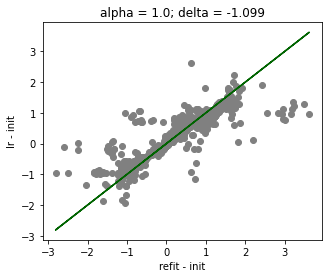

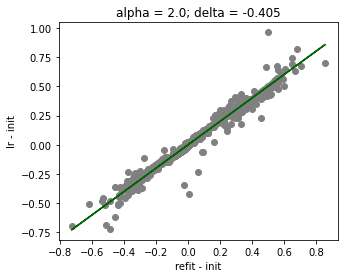

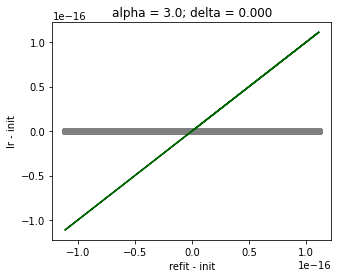

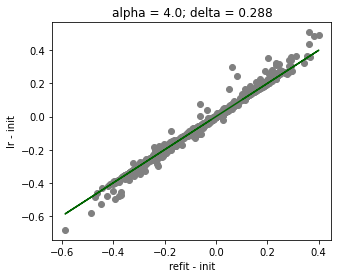

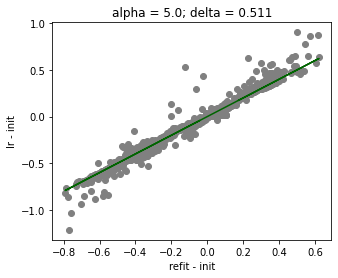

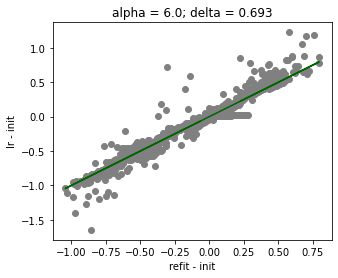

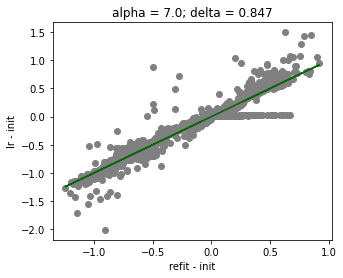

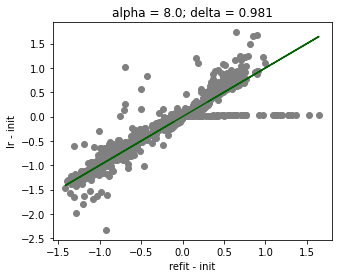

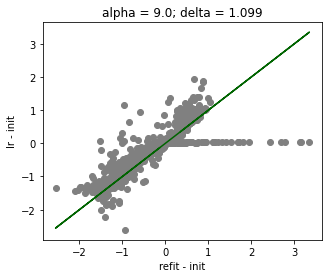

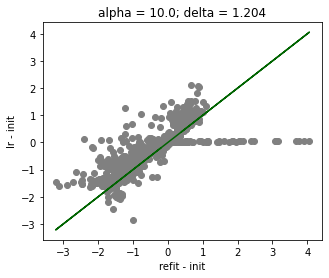

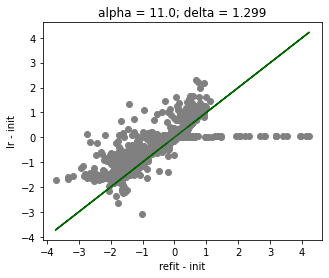

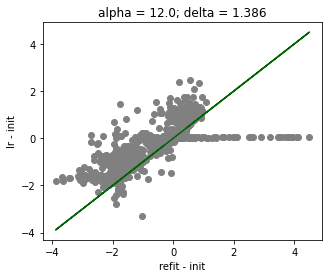

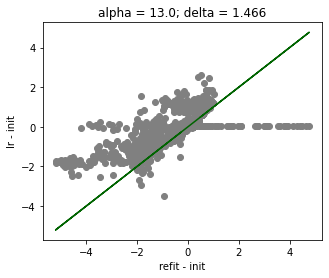

In [34]:
for i in range(len(alpha_list)): 
    fig, ax = plt.subplots(1, 1, figsize = (5, 4))

    result_loading_utils.print_diff_plot(refit_list[i], 
                                         lr_list[i],
                                         vb_opt,
                                         ax, 
                                         alpha = 1.)
    
    alpha = alpha_list[i]
    hyper_param_pert = prior_params_paragami['dp_prior_alpha'].flatten(alpha,
                                                                       free = use_free_alpha)
    delta = hyper_param_pert - hyper_param0
    plt.title('alpha = ' + str(alpha) + '; delta = {:.03f}'.format(delta[0]))
    

In [35]:
def get_inferred_admixture_and_plot(vb_free_params, ax): 
    # get inferred admixture
    e_ind_admix = posterior_quantities_lib.get_vb_expectations(vb_params_paragami.fold(vb_free_params, free = True), 
                                                               gh_loc,
                                                               gh_weights)[0]
    
    # plot admixtures
    plotting_utils.plot_top_clusters(onp.array(e_ind_admix)[perm_obs], 
                                     ax,
                                     8, 
                                     cmap_colors = plt.get_cmap('Set2').colors);

    # print labels 
    plotting_utils.draw_region_separation(labels[perm_labels], ax);

In [36]:
alpha_list

DeviceArray([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
             13.], dtype=float64)

In [37]:
# for i in range(5): 

#     fig, ax = plt.subplots(1, 2, figsize = (16, 4.5))
    
#     # refit
#     get_inferred_admixture_and_plot(refit_list[i], ax[0])
#     ax[0].set_title('refit at alpha = {}'.format(alpha_list[i]))
    
#     # lr 
#     get_inferred_admixture_and_plot(lr_list[i], ax[1])
#     ax[1].set_title('lr at alpha = {}'.format(alpha_list[i]))
    
#     fig.tight_layout()

# Number of clusters

In [38]:
prng_key = jax.random.PRNGKey(223)

@jax.jit
def get_n_clusters_insample(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.get_e_num_clusters(g_obs,
                                                       vb_params_dict,
                                                       gh_loc,
                                                       gh_weights,
                                                       threshold = 0,
                                                       n_samples = 10000, 
                                                       prng_key = prng_key)

@jax.jit
def get_n_clusters_pred(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.get_e_num_pred_clusters(vb_params_dict,
                                                            gh_loc, 
                                                            gh_weights, 
                                                            threshold = 0,
                                                            prng_key = prng_key)

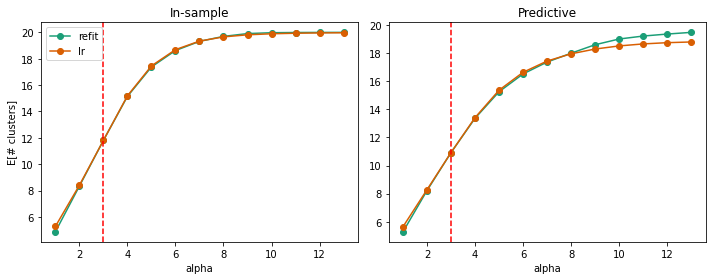

In [40]:
fig, axarr = plt.subplots(1, 2, figsize = (10, 4))

# in sample number of clusters
result_loading_utils.plot_post_stat_per_epsilon(get_n_clusters_insample, 
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               axarr[0])
axarr[0].legend()
axarr[0].set_title('In-sample')
axarr[0].set_ylabel('E[# clusters]')

# predictive number of clusters
result_loading_utils.plot_post_stat_per_epsilon(get_n_clusters_pred, 
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               axarr[1])

axarr[1].set_title('Predictive')

for i in range(2):
    axarr[i].axvline(alpha0, 
                     color = 'red', 
                     linestyle = '--')
    axarr[i].set_xlabel('alpha')
    


fig.tight_layout()

### Thresholded

In [41]:
prng_key = jax.random.PRNGKey(223)

threshold1 = 20 # np.ceil((n_obs * n_loci * 2) * 0.01)
threshold2 = np.ceil(n_obs * 0.01)

print(threshold1)
print(threshold2)

@jax.jit
def get_n_clusters_insample_thresh(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.get_e_num_clusters(g_obs,
                                                            vb_params_dict,
                                                            gh_loc, gh_weights,
                                                            threshold = threshold1,
                                                            n_samples = 1000, 
                                                            prng_key = prng_key)

@jax.jit
def get_n_clusters_pred_thresh(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.get_e_num_pred_clusters(vb_params_dict,
                                                            gh_loc, 
                                                            gh_weights, 
                                                            n_samples = 1000,
                                                            threshold = threshold2,
                                                            prng_key = prng_key)

20
2.0


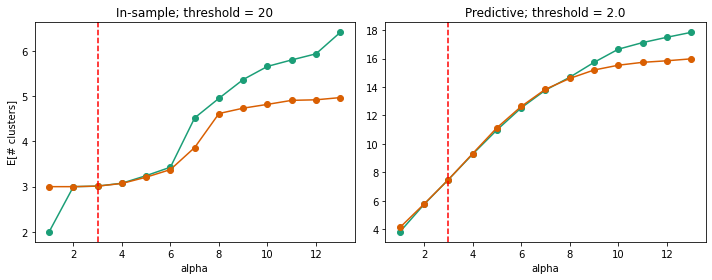

In [42]:
fig, axarr = plt.subplots(1, 2, figsize = (10, 4))

# in sample number of clusters
result_loading_utils.plot_post_stat_per_epsilon(get_n_clusters_insample_thresh, 
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               axarr[0])
# axarr[0].legend()
axarr[0].set_title('In-sample; threshold = {}'.format(threshold1))
axarr[0].set_ylabel('E[# clusters]')

# predictive number of clusters
result_loading_utils.plot_post_stat_per_epsilon(get_n_clusters_pred_thresh,
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               axarr[1])
axarr[1].set_title('Predictive; threshold = {}'.format(threshold2))

for i in range(2):
    axarr[i].axvline(alpha0, 
                     color = 'red', 
                     linestyle = '--')
    axarr[i].set_xlabel('alpha')

fig.tight_layout()

# Cluster weights

In [44]:
def get_cluster_weights(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.get_e_num_loci_per_cluster(g_obs, vb_params_dict, gh_loc, gh_weights)
#     return posterior_quantities_lib.get_e_num_ind_per_cluster(vb_params_dict, gh_loc, gh_weights)

In [47]:
def plot_e_num_obs_trace(): 
    
    # get arrays of mixture weights
    refit_array = result_loading_utils.get_post_stat_vec(get_cluster_weights, refit_list)
    lr_array = result_loading_utils.get_post_stat_vec(get_cluster_weights, lr_list)
    
        
    fig, ax = plt.subplots(2, 4, figsize = (16, 6), sharex = True) 
    
    for k in range(8): 
        x0 = k // 4
        x1 = k % 4
        ax[x0, x1].plot(alpha_list, 
                       refit_array[:, k], 
                       '-o',
                       color = result_loading_utils.refit_color, 
                       label = 'refit')
        
        ax[x0, x1].plot(alpha_list, 
                       lr_array[:, k], 
                       '-o',
                       color = result_loading_utils.lr_color, 
                       label = 'lr')
        
        ax[x0, x1].set_title('k = {}'.format(k))
        ax[x0, x1].axvline(alpha0, 
                           color = 'red', 
                           linestyle = '--')
        
        
        if k == 0: 
            ax[x0, x1].legend()
            
    for k in range(4): 
        ax[-1, k].set_xlabel('alpha')
        
    for k in range(2): 
        ax[k, 0].set_ylabel('E(# loci)')
    
    fig.tight_layout()


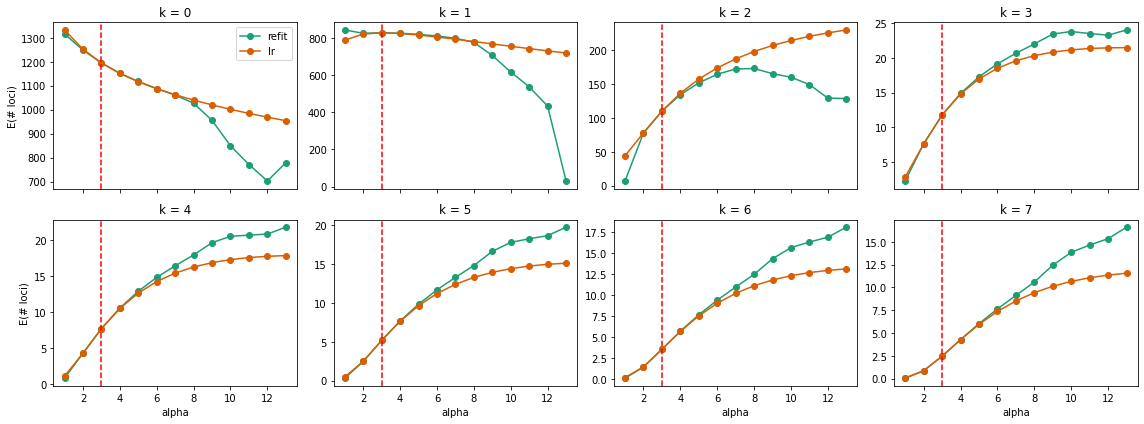

In [48]:
plot_e_num_obs_trace()

### Save sensitivity results

In [49]:
np.savez(out_datadir + 'alpha_sens', 
        n_clusters_refit = result_loading_utils.get_post_stat_vec(get_n_clusters_insample, 
                                                                         refit_list),
        n_clusters_lr = result_loading_utils.get_post_stat_vec(get_n_clusters_insample, 
                                                                      lr_list),
        n_clusters_thresh_refit = result_loading_utils.get_post_stat_vec(get_n_clusters_insample_thresh, 
                                                                         refit_list),
        n_clusters_thresh_lr = result_loading_utils.get_post_stat_vec(get_n_clusters_insample_thresh, 
                                                                      lr_list),
        cluster_weights_refit = result_loading_utils.get_post_stat_vec(get_cluster_weights, refit_list),
        cluster_weights_lr = result_loading_utils.get_post_stat_vec(get_cluster_weights, lr_list), 
        alpha_list = alpha_list, 
        threshold = threshold1, 
        alpha0 = alpha0)